In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier



In [29]:
df_bris = pd.read_csv("/content/brisbane_water_quality.csv")
df_bris.tail()

,Timestamp,Record number,Average Water Speed,Average Water Direction,Chlorophyll,Chlorophyll [quality],Temperature,Temperature [quality],Dissolved Oxygen,Dissolved Oxygen [quality],Dissolved Oxygen (%Saturation),Dissolved Oxygen (%Saturation) [quality],pH,pH [quality],Salinity,Salinity [quality],Specific Conductance,Specific Conductance [quality],Turbidity,Turbidity [quality]
30889,2024-06-27 08:20:00,32357,13.314,82.720,0.944,1020.0,18.607,1020.0,6.876,1020.0,87.556,1020.0,8.151,1020.0,29.268,1020.0,45.134,1020.0,3.963,1020.0
30890,2024-06-27 08:30:00,32358,32.617,18.081,1.161,1020.0,18.551,1020.0,6.918,1020.0,87.987,1020.0,8.163,1020.0,29.254,1020.0,45.115,1020.0,3.928,1020.0
30891,2024-06-27 08:40:00,32359,8.552,306.184,1.192,1020.0,18.558,1020.0,6.651,1020.0,84.606,1020.0,8.145,1020.0,29.250,1020.0,45.110,1020.0,4.097,1020.0
30892,2024-06-27 08:50:00,32360,10.341,24.711,1.031,1020.0,18.547,1020.0,6.740,1020.0,85.713,1020.0,8.154,1020.0,29.247,1020.0,45.105,1020.0,4.962,1020.0
30893,2024-06-27 09:00:00,32361,11.173,241.662,0.946,1020.0,18.562,1020.0,5.842,1020.0,74.326,1020.0,8.116,1020.0,29.258,1020.0,45.121,1020.0,5.078,1020.0


In [30]:
# df_bris.info()
df_bris.columns

Index(['Timestamp', 'Record number', 'Average Water Speed',
       'Average Water Direction', 'Chlorophyll', 'Chlorophyll [quality]',
       'Temperature', 'Temperature [quality]', 'Dissolved Oxygen',
       'Dissolved Oxygen [quality]', 'Dissolved Oxygen (%Saturation)',
       'Dissolved Oxygen (%Saturation) [quality]', 'pH', 'pH [quality]',
       'Salinity', 'Salinity [quality]', 'Specific Conductance',
       'Specific Conductance [quality]', 'Turbidity', 'Turbidity [quality]'],
      dtype='object')

In [31]:
# Dropping the quality columns because the all carry came value "1020.0" data redundancy
df_bris.drop(columns=['Timestamp','Chlorophyll [quality]', 'Temperature [quality]','Dissolved Oxygen [quality]', 'pH [quality]','Salinity [quality]',
                      'Specific Conductance [quality]','Turbidity [quality]','Dissolved Oxygen (%Saturation) [quality]',], inplace=True)

In [32]:
df_bris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30894 entries, 0 to 30893
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Record number                   30894 non-null  int64  
 1   Average Water Speed             30874 non-null  float64
 2   Average Water Direction         30893 non-null  float64
 3   Chlorophyll                     30309 non-null  float64
 4   Temperature                     25730 non-null  float64
 5   Dissolved Oxygen                26594 non-null  float64
 6   Dissolved Oxygen (%Saturation)  25145 non-null  float64
 7   pH                              29810 non-null  float64
 8   Salinity                        26936 non-null  float64
 9   Specific Conductance            29527 non-null  float64
 10  Turbidity                       28894 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 2.6 MB


In [33]:
# The columns with missing values
cols = ['Average Water Speed', 'Average Water Direction', 'Chlorophyll',
       'Temperature', 'Dissolved Oxygen', 'Dissolved Oxygen (%Saturation)',
       'pH', 'Salinity', 'Specific Conductance', 'Turbidity']

# Fill NaN in each column with that column's mean
df_bris[cols] = df_bris[cols].apply(lambda x: x.fillna(x.mean()))

In [34]:
# Inspeating the data set
df_bris.isnull().sum()

,0
Record number,0
Average Water Speed,0
Average Water Direction,0
Chlorophyll,0
Temperature,0
Dissolved Oxygen,0
Dissolved Oxygen (%Saturation),0
pH,0
Salinity,0
Specific Conductance,0


In [35]:
# Setting up the Water Quality Index (WHO/CCME guideline, adjust as needed)
objectives = {
    "pH": (6.5, 8.5),                       # acceptable pH range
    "Dissolved Oxygen": (6, np.inf),        # mg/L, min threshold
    "Chlorophyll": (0, 50),                 # µg/L, high levels indicate eutrophication
    "Turbidity": (0, 5),                    # NTU
    "Temperature": (0, 25),                 # °C
    "Salinity": (0, 500),                   # mg/L or ppm
    "Specific Conductance": (0, 1500),      # µS/cm
    "Dissolved Oxygen (%Saturation)": (80, 120)  # % saturation safe range
}



In [36]:
# Row-wise CCME-WQI calculation
def compute_wqi_row(row, objectives):
    excursions = []
    failed_params = 0
    failed_tests = 0
    n_params = len(objectives)

    for param, (min_val, max_val) in objectives.items():
        val = row[param]
        if pd.isna(val):
            continue

        if val < min_val:
            failed_tests += 1
            failed_params += 1
            excursions.append((min_val / val) - 1)
        elif val > max_val:
            failed_tests += 1
            failed_params += 1
            excursions.append((val / max_val) - 1)

    # F1: scope (% of parameters failed)
    F1 = (failed_params / n_params) * 100

    # F2: frequency (% of tests failed)
    F2 = (failed_tests / n_params) * 100

    # F3: amplitude (normalized excursions)
    F3 = (np.mean(excursions) / (0.01 * np.mean(excursions) + 0.01)) if excursions else 0

    # Final WQI
    WQI = 100 - (np.sqrt(F1**2 + F2**2 + F3**2) / 1.732)

    return WQI

In [37]:
# Apply row-wise WQI computation
df_bris["WQI"] = df_bris.apply(lambda row: compute_wqi_row(row, objectives), axis=1)

# Categorize WQI
def categorize_wqi(wqi):
    if wqi >= 80:
        return 0  # Excellent
    elif wqi >= 65:
        return 1  # Good
    elif wqi >= 45:
        return 2  # Fair
    else:
        return 3  # Poor

In [38]:
# Apply the categorization function to WQI scores and create a target column
df_bris["Quality"] = df_bris["WQI"].apply(categorize_wqi)

# Define features (X) and target (y)
X = df_bris.drop(columns=["Quality", "WQI"])
y = df_bris["Quality"]

In [39]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Data type conversion
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

In [43]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **Random Forest**

In [44]:
# Setup and fitting of the Random fores model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,          # shallow trees
    min_samples_leaf=20,  # prevent tiny leaves
    max_features="sqrt",
    max_samples=0.7,      # sub-sample rows
    class_weight="balanced",
    random_state=42
)

# Fitting the model
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_samples=0.7,
                       min_samples_leaf=20, n_estimators=200, random_state=42)

In [46]:
# Model Prediction
y_pred_rf = rf_model.predict(X_test_scaled)

In [50]:
# Model Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      5131
           1       0.83      0.97      0.89       839
           2       0.97      0.97      0.97       209

    accuracy                           0.97      6179
   macro avg       0.93      0.97      0.95      6179
weighted avg       0.97      0.97      0.97      6179



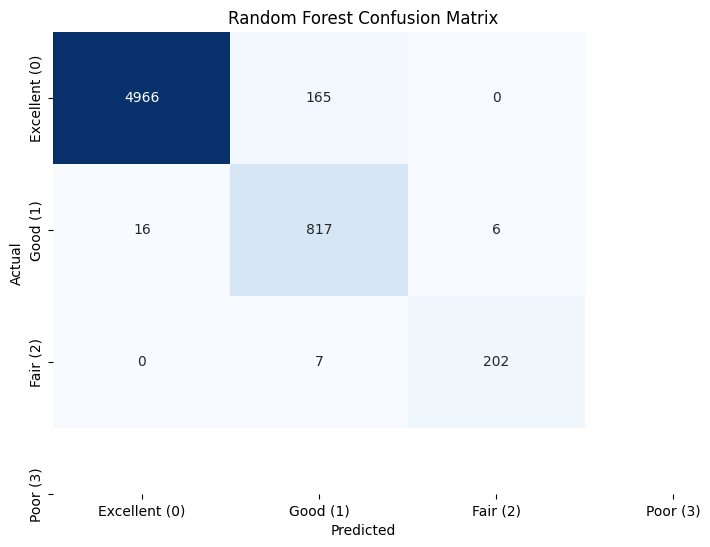

In [51]:
# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Excellent (0)', 'Good (1)', 'Fair (2)', 'Poor (3)'],
            yticklabels=['Excellent (0)', 'Good (1)', 'Fair (2)', 'Poor (3)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

### **K-Nearest Neighbours**

In [52]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [73]:
y_pred_knn = knn_model.predict(X_test_scaled)

In [74]:
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5131
           1       0.88      0.80      0.84       839
           2       0.98      0.89      0.93       209

    accuracy                           0.96      6179
   macro avg       0.94      0.89      0.92      6179
weighted avg       0.96      0.96      0.96      6179



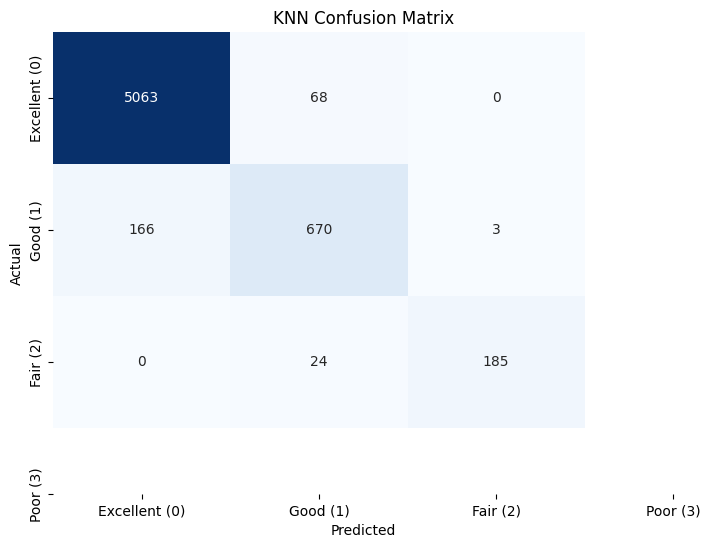

In [75]:
# KNN Model Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Excellent (0)', 'Good (1)', 'Fair (2)', 'Poor (3)'],
            yticklabels=['Excellent (0)', 'Good (1)', 'Fair (2)', 'Poor (3)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Confusion Matrix')
plt.show()

### **XGBoost**

In [56]:
# XGBoost Model setup
xgb_model = XGBClassifier(
    max_depth=2,
    min_child_weight=20,
    gamma=4.0,
    subsample=0.5,
    colsample_bytree=0.5,
    reg_alpha=2.0,
    reg_lambda=4.0,
    learning_rate=0.02
)

xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=4.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=20, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [57]:
# Model Preditions
y_pred_xgb = xgb_model.predict(X_test_scaled)

In [58]:
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5131
           1       0.97      0.78      0.86       839
           2       0.94      0.95      0.94       209

    accuracy                           0.97      6179
   macro avg       0.96      0.91      0.93      6179
weighted avg       0.97      0.97      0.96      6179



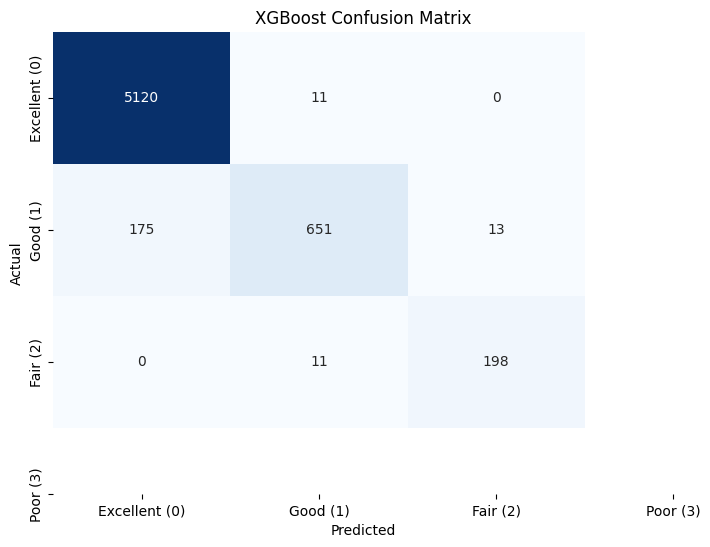

In [59]:
# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Excellent (0)', 'Good (1)', 'Fair (2)', 'Poor (3)'],
            yticklabels=['Excellent (0)', 'Good (1)', 'Fair (2)', 'Poor (3)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

In [60]:
# Decision Tree Model setup
adb_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(
        max_depth=2,         # shallow, but not too restrictive
        min_samples_leaf=25  # larger leaves, less variance
    ),
    n_estimators=200,        # fewer boosting rounds
    learning_rate=0.08,      # softer step size
    algorithm="SAMME",
    random_state=42
)

adb_model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=25),
                   learning_rate=0.08, n_estimators=200, random_state=42)

In [62]:
# Model Prediction
y_pred_adb = adb_model.predict(X_test_scaled)

In [63]:
print("Classification Report:")
print(classification_report(y_test, y_pred_adb))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5131
           1       0.99      0.97      0.98       839
           2       0.97      0.96      0.97       209

    accuracy                           0.99      6179
   macro avg       0.99      0.98      0.98      6179
weighted avg       0.99      0.99      0.99      6179



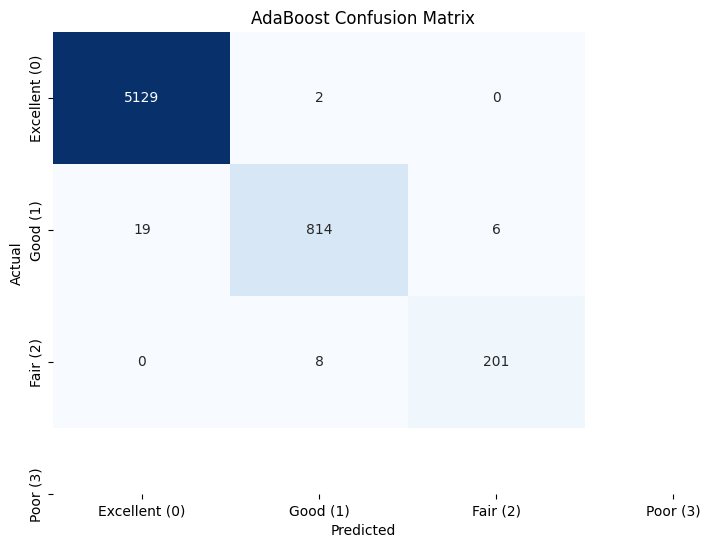

In [65]:
# Model Confusion matrix Plot
cm = confusion_matrix(y_test, y_pred_adb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Excellent (0)', 'Good (1)', 'Fair (2)', 'Poor (3)'],
            yticklabels=['Excellent (0)', 'Good (1)', 'Fair (2)', 'Poor (3)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('AdaBoost Confusion Matrix')
plt.show()

### **Support Vector Machine (SVM)**

In [66]:
# SVM Model Setup
svm = SVC(
    kernel="rbf",          # nonlinear, but with controlled complexity
    C=1.0,                 # regularization strength (smaller = stronger regularization)
    gamma="scale",         # kernel coefficient, auto-scaled by data
    class_weight="balanced", # handle class imbalance automatically
    probability=True,      # enable predict_proba for metrics/ensembles
    random_state=42
)

svm.fit(X_train_scaled, y_train)

SVC(class_weight='balanced', probability=True, random_state=42)

In [67]:
# Model Prediction
y_pred_svm = svm.predict(X_test_scaled)

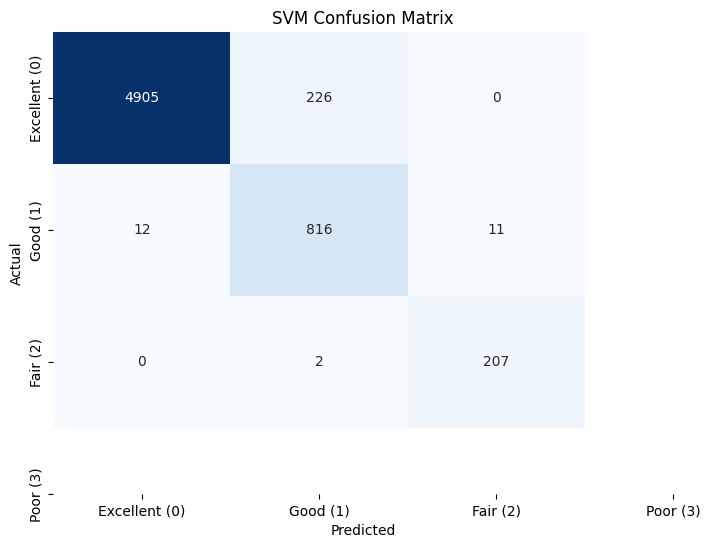

In [68]:
# Model Confusion Matrix Setup
cm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Excellent (0)', 'Good (1)', 'Fair (2)', 'Poor (3)'],
            yticklabels=['Excellent (0)', 'Good (1)', 'Fair (2)', 'Poor (3)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()

### **Artificial Neural Network**

In [69]:
# ANN Model Setup

mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    alpha=1e-3,                # L2
    learning_rate_init=1e-3,
    batch_size=256,
    max_iter=300,
    early_stopping=True,
    n_iter_no_change=20,
    validation_fraction=0.15,
    shuffle=True,
    tol=1e-4,
    random_state=42
)

mlp.fit(X_train_scaled, y_train)


MLPClassifier(alpha=0.001, batch_size=256, early_stopping=True,
              hidden_layer_sizes=(64, 32), max_iter=300, n_iter_no_change=20,
              random_state=42, validation_fraction=0.15)

In [70]:
# Model Prediction
y_pred_ann = mlp.predict(X_test_scaled)

In [71]:
# Model Classification
print("Classification Report:")
print(classification_report(y_test, y_pred_ann))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5131
           1       0.97      0.94      0.95       839
           2       0.96      0.99      0.97       209

    accuracy                           0.99      6179
   macro avg       0.97      0.97      0.97      6179
weighted avg       0.99      0.99      0.99      6179



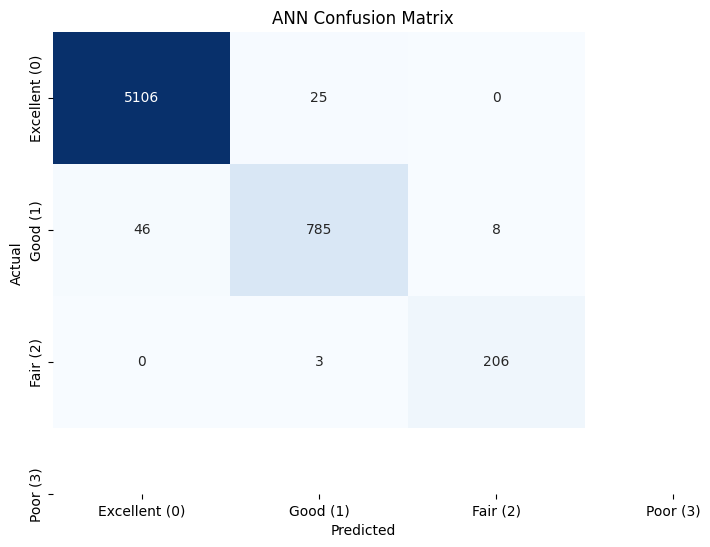

In [72]:
# Model Confussion Matrix Plot
cm = confusion_matrix(y_test, y_pred_ann)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Excellent (0)', 'Good (1)', 'Fair (2)', 'Poor (3)'],
            yticklabels=['Excellent (0)', 'Good (1)', 'Fair (2)', 'Poor (3)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ANN Confusion Matrix')
plt.show()

# 📊 Model Performance Report: Water Quality Classification

## 🔎 Comparison Table

| Model              | Accuracy | Precision (macro avg) | Recall (macro avg) | F1-score (macro avg) |
|--------------------|----------|------------------------|---------------------|-----------------------|
| Random Forest      | 0.97     | 0.93                   | 0.97                | 0.95                  |
| KNN                | 0.96     | 0.94                   | 0.89                | 0.92                  |
| XGBoost            | 0.97     | 0.96                   | 0.90                | 0.92                  |
| Decision Tree      | 0.99     | 0.99                   | 0.98                | 0.98                  |
| SVM                | 0.96     | 0.91                   | 0.97                | 0.94                  |
| ANN (MLPClassifier)| 0.99     | 0.97                   | 0.97                | 0.97                  |

---

## 📝 Narrative Analysis

1. **Decision Tree (Accuracy: 0.99)**  
   - Achieved the **highest accuracy** of all models.  
   - Extremely strong across all classes with precision, recall, and F1 above 0.97.  
   - However, Decision Trees are prone to **overfitting** — the very high scores could mean it memorized the training patterns rather than generalizing.  

2. **ANN (Accuracy: 0.99)**  
   - Also very strong and comparable to the Decision Tree.  
   - Balanced precision, recall, and F1 across classes (all ~0.97+).  
   - More robust to generalization than Decision Trees if tuned well, making it a **reliable top-performing model**.  

3. **Random Forest (Accuracy: 0.97)**  
   - Excellent balance with strong recall (0.97) and good precision (0.93).  
   - Better generalization expected than a single Decision Tree because it’s an ensemble.  
   - Solid choice if interpretability is less critical.  

4. **XGBoost (Accuracy: 0.97)**  
   - Matches Random Forest in accuracy.  
   - Slightly higher precision (0.96) but slightly lower recall (0.90).  
   - Shows that XGBoost is precise but sometimes sacrifices recall (may miss some minority class cases).  

5. **SVM (Accuracy: 0.96)**  
   - Strong recall (0.97) but relatively lower precision (0.91).  
   - This suggests SVM captured most true cases but made more **false positives** compared to Random Forest/XGBoost.  

6. **KNN (Accuracy: 0.96)**  
   - Solid performance but the **lowest recall (0.89)** among all models.  
   - Indicates it struggles more with minority classes compared to the ensembles and ANN.  

---

## 📌 Key Takeaways

- **Top performers**:  
  - **Decision Tree (0.99)** and **ANN (0.99)** — both excellent, though ANN is likely to generalize better.  
  - **Random Forest** and **XGBoost** (both 0.97) — highly reliable, slightly lower but very stable.  

- **Middle tier**:  
  - **SVM** and **KNN** (0.96 each) — good models but lag slightly in precision/recall balance.  

- **Recommendation**:  
  - Use **ANN or Random Forest** as your primary model.  
  - **Decision Tree** looks very strong but may overfit — validate carefully on unseen test data.  
  - Keep **XGBoost** as a secondary choice for robust performance.  
